In [ ]:
##############################################################
### Set up libraries and global variables
##############################################################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.constants as constants  # a collection of scientific constants
from scipy.optimize import curve_fit
from scipy.stats import linregress

!pip install uncertainties

import uncertainties as un
from uncertainties import unumpy as unp

github_location_styles = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/styles/"
github_location_LFER_tables = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/data/"

#################################################################
### a function to fill in sigma for empty spaces in s+ and s- 
#################################################################

def fill_sigma(df):     
    for z in df.index:
        if np.isnan(df.loc[z,"s_plus"]):
            df.loc[z,"s_plus"] = df.loc[z,"sigma"]
        if np.isnan(df["s_minus"][z]):
            df.loc[z,"s_minus"] = df.loc[z,"sigma"]
    return(df)

#################################################################
### a function calculate rsq for data and a model with parameters
#################################################################

def rsq(x, y, popt, model):
    ### RSQ calc from https://stackoverflow.com/questions/19189362/getting-the-r-squared-value-using-curve-fit
    y_calc = model(x, *popt)
    residuals = y-y_calc
    
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y-np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)   # calculate correlation constant rsq
    return(r_squared)



In [3]:
################################################################################
### Read Hammett data set. The fields are separated by commas; comments are enabled  
################################################################################

#LFER_Data = "LFER_HanschLeoTaft.csv"   # Choose which set of Hammett parameters you prefer
LFER_Data = "LFER_Williams.csv"

Filename = github_location_LFER_tables + LFER_Data

df = pd.read_csv(Filename,            # load in substituent constants from database
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col="Substituent", 
                 comment = "#") 
#display(df)

################################################################################
### Fill across sigma values and select substituents 
################################################################################

df = fill_sigma(df)
#display(df2)

################################################################################
### Remove unneeded columns 
################################################################################
 
#df.drop(labels = ["TABLE V", "TABLE I"],    #Trim "LFER_HanschLeoTaft.csv" data
df.drop(labels = ["Page"],                   #Trim "LFER_Williams.csv"" data
        axis = 1,
        inplace = True)

df.sort_values(by=['sigma'], inplace=True)

#result = pd.concat([df2, df], axis=1, join="inner")   # combine the experimental data and the Hammett parameters



In [4]:
################################################################################
### Data for plot
################################################################################

list = ["m-Br", "p-OCH3", "p-Cl", "p-Br", "p-CH3", "m-CH3", "p-CN", "m-NO2", "p-NO2",]
x = df["sigma"][list]   # pull out corresponding sigma values from dataframe

numbers = np.array([0.18, 1, 0.2, 0.25, 0.8, 0.75, 0.05, 0.05, 0.04])
y = np.log10(numbers)


#plt.plot(x, y, "ko")


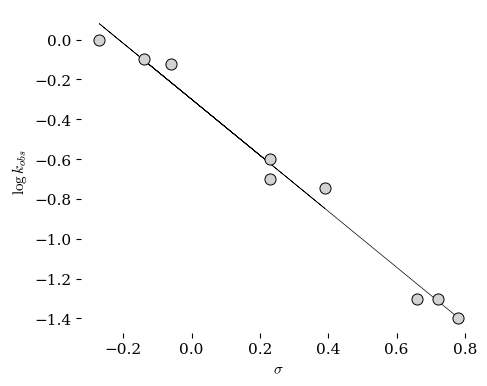

slope is -1.405+/-0.066
intercept is -0.300+/-0.031
rsq is 0.985


In [8]:
################################################################################
### Define Models and other functions
################################################################################

def linear_model(x, m, b):
       y = m*x + b
       return(y)

################################################################################
### Curve Fit to Model
################################################################################

popt, pcov = curve_fit(linear_model, x, y)   # curve fit data to model

################################################################################
### Plot Data
################################################################################

plt.rcdefaults()                  # reset plot styles (just in case)

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)         # use a chosen style sheet (or not)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))    # create empty plot
#ax.margins(x=.07, y=.07, tight=True)

ax.scatter(x, y,                  # plot the data points
           s=64, color="lightgray", marker='o', 
           edgecolors = "black", linewidth = 0.7, 
           alpha = 1, zorder=3)

y_calc = linear_model(x, *popt)   # calculate line values using optimize parameters

ax.plot(x, y_calc,                # plot the line for optimized parameters
           color="black", marker=None, 
           linewidth = 0.5, 
           alpha = 1, zorder=2)

ax.set(                           # set options for plot appearance
#    title="Yukawa-Tsuno Plot",       
          ylabel=r"$\log{k_{obs}}$", 
          xlabel=r"$\sigma$",                
#          xlim=[-.9,.9],                  
#          ylim=[-3.7,-2.7]
       )

fig.savefig("starter.pdf")   # use this to save the figure in PDF format
plt.show()

################################################################################
### report
################################################################################

popt_u = un.correlated_values(popt,pcov) # use covariance matrix and parameters to make uncertain parameters

print(f"slope is {popt_u[0]:0.3f}")
print(f"intercept is {popt_u[1]:0.3f}")
print(f"rsq is {rsq(x,y,popt,linear_model):0.3f}")